# Прогнозирование оттока клиентов банка

**Описание проекта**

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Задача**

На основе данных из банка определить клиента, который может уйти.

Таким образом, исследование пройдёт в четыре этапа:

1. Подготовка данных.
2. Исследование задачи.
3. Борьба с дисбалансом.
4. Тестирование модели.


## Подготовка данных

### Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import accuracy_score
import random



In [2]:
df = pd.read_csv('/datasets/Churn.csv')
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


In [5]:
df.duplicated().sum()

0

**Вывод** 

Файл содержит 14 столбцов, из них 3 столбца имеют тип данных float64, 3 столбца object, 8 столбцов int64, и 10000 строк. 

В столбце **Tenure** обнаружены пропущенные значения. 

Дубликаты не найдены.

Каждый объект в наборе данных — это информация о поведении клиента и расторжении договора с банком.

Признаки:
*	`RowNumber` — индекс строки в данных
*	`CustomerId` — уникальный идентификатор клиента
*	`Surname` — фамилия
*	`CreditScore` — кредитный рейтинг
*	`Geography` — страна проживания
*	`Gender` — пол
*	`Age` — возраст
*	`Tenure` — сколько лет человек является клиентом банка
*	`Balance` — баланс на счёте
*	`NumOfProducts` — количество продуктов банка, используемых клиентом
*	`HasCrCard` — наличие кредитной карты
*	`IsActiveMember` — активность клиента
*	`EstimatedSalary` — предполагаемая зарплата

Целевой признак:
*	`Exited` — факт ухода клиента

### Анализ признаков и заполнение пропусков

Три признака  **RowNumber** (индекс строки в данных), **CustomerId** (уникальный идентификатор клиента) и **Surname** (фамилия) являются лишними, так как они уникальны. Создадим переменную без них.

In [6]:
df_drop = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
print(df_drop.shape)
df_drop.head()

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Пропущенные значения наблюдаются только в одном столбце **Tenure** (сколько лет человек является клиентом банка). Средняя и медиана 5 лет, посмотрим эти значения в зависимости от факта ухода из банка и количеством продуктов банка, используемых клиентом.

In [8]:
(df_drop
 .pivot_table(index='Exited', columns='NumOfProducts', 
              values='Tenure', aggfunc=['count', 'mean', 'median']))

count                           mean                     \
NumOfProducts       1       2      3     4         1         2        3   
Exited                                                                    
0              3334.0  3862.0   41.0   NaN  4.994001  5.047126  4.97561   
1              1283.0   322.0  193.0  56.0  4.884645  4.854037  5.00000   

                        median                 
NumOfProducts         4      1    2    3    4  
Exited                                         
0                   NaN    5.0  5.0  4.0  NaN  
1              5.232143    5.0  5.0  5.0  5.0

In [9]:
(df_drop.query('Tenure.isna()')
 .pivot_table(index='Exited', columns='NumOfProducts', values='Age', aggfunc='count'))

NumOfProducts,1,2,3,4
Exited,,,,
0,341.0,380.0,5.0,NaN
1,126.0,26.0,27.0,4.0


Таким образом, заменим пропущенные значения случайными числами, так как распределение по годам использования банка практически ровное.

In [10]:
df_drop['Tenure'] = df_drop['Tenure'].fillna(random.randint(0, 10))
len(df_drop.query('Tenure.isna()'))                                             

0

### Преобразование категориальных признаков

В двух столбцах тип данных object: **Geography** (страна проживания) и **Gender** (пол). Преобразуем категориальные признаки в численные с помощью техники прямого кодирования.

In [11]:
df_drop['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [12]:
df_drop['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [13]:
df_drop_ohe = pd.get_dummies(df_drop, drop_first=True)
print(df_drop_ohe.shape)
df_drop_ohe.head()

(10000, 12)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Разделение данных на выборки

**Создадим переменные для признаков и целевого признака для каждой выборки: обучающей, валидационной и тестовой.**

In [14]:
target = df_drop_ohe['Exited']
features = df_drop_ohe.drop('Exited', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


### Масштабирование признаков

In [15]:
df_drop_ohe.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,4.907000,2.774873,0.00,3.00,4.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
Geography_Germany,10000.0,0.250900,0.433553,0.00,0.00,0.000,1.0000,1.00


Четыре признака **CreditScore**, **Age**, **Balance**, **EstimatedSalary** имеют разный масштаб. Преобразуем масштаб методом стандартизации данных.

In [16]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

print(features_train.shape)
features_train.head()

(6000, 11)


/tmp/ipykernel_196/648638124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,6.0,0.774657,1,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,4.0,1.910540,1,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,8.0,0.481608,2,0,1,1.422836,0,0,1
660,-0.184996,0.190726,4.0,0.088439,1,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,1.0,0.879129,1,1,0,0.113236,0,0,0


## Исследование задачи

### Анализ баланса классов

**Исследуем баланс классов, проверим как часто в целевом признаке встречается клас "1" и "0.**

0    0.7963
1    0.2037
Name: Exited, dtype: float64


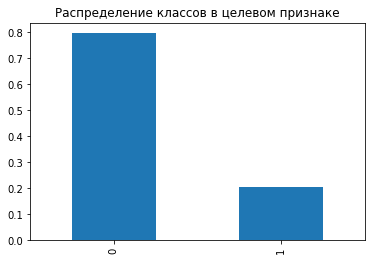

In [17]:
class_frequency = df_drop_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', title='Распределение классов в целевом признаке')
plt.show()

**Наблюдается сильный дисбаланс классов, соотношение классов 8:2.**

### Модель "Дерево решений"

Проверим качество моделей для гиперпараметра maх_depth (глубина дерева) от 1 до 10. Для каждого значения выведем F1-меру на валидационной выборке.

In [18]:
for depth in range(1,11):
    model_tree=DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid= model_tree.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 =", f1_score(target_valid, predictions_valid))

max_depth = 1 : F1 = 0.0
max_depth = 2 : F1 = 0.5203488372093023
max_depth = 3 : F1 = 0.5375722543352601
max_depth = 4 : F1 = 0.5206349206349208
max_depth = 5 : F1 = 0.5454545454545455
max_depth = 6 : F1 = 0.5787878787878787
max_depth = 7 : F1 = 0.5924855491329479
max_depth = 8 : F1 = 0.5601217656012176
max_depth = 9 : F1 = 0.5486725663716815
max_depth = 10 : F1 = 0.5534950071326676


Наибольшее значение F1= 0.592, при max_depth=7.

In [19]:
model_tree=DecisionTreeClassifier(random_state=12345, max_depth=7)
model_tree.fit(features_train, target_train)
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))

AUC-ROC = 0.8230390617302197


### Модель "Cлучайный лес

**Обучим модель случайного леса с гиперпараметрами n_estimators от 1 до 100. Найдем наилучшую модель и ее  F1-меру на валидационной выборке.**

In [20]:
best_model = None
best_result = 0
for est in range(1, 101):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model_forest.fit(features_train, target_train) 
    predictions_valid = model_forest.predict(features_valid)
    result = f1_score(target_valid, predictions_valid) 
    if result > best_result:
        best_model = model_forest
        best_result = result

print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Наилучшая модель:", best_model)

F1-мера наилучшей модели на валидационной выборке: 0.6108663729809104
Наилучшая модель: RandomForestClassifier(n_estimators=77, random_state=12345)


In [21]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=77) 
model_forest.fit(features_train, target_train) 
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))

AUC-ROC = 0.8601763412651492


### Логистическая регрессия

In [22]:
model_logist = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_logist.fit(features_train, target_train)

predictions_valid = model_logist.predict(features_valid)

print("F1-мера на валидационной выборке:", f1_score(target_valid, predictions_valid))

F1-мера на валидационной выборке: 0.30458715596330277


In [23]:
probabilities_valid = model_logist.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))

AUC-ROC = 0.7874713641738101


### Вывод

Рассмотрены три модели машинного обучения, без учета дисбаланса классов, получены следующие наилучшие значения f1-меры на валидационной выборке:
1. **Модель"Дерево решений":** 
* Наибольшее значение F1=0.592, при max_depth=7.
* AUC-ROC = 0.823

2. **Модель "Случайный лес":**
*  F1=0.611, при n_estimators=77.
* AUC-ROC = 0.860

3. **Модель "Логистическая регрессия":**
*  F1=0.305
* AUC-ROC = 0.787


**Таким образом, наилучшие значения f1-меры у модели "Случайный лес": F1=0.611, при n_estimators=77 и AUC-ROC = 0.860, качество лучше, чем у случайной модели.**

## Борьба с дисбалансом

Для увеличения качества моделей при дисбалансе классов применим следующие техники: **взвешивание классов**, **upsampling**, **downsampling**.

Напишем функцию upsampling() с тремя аргументами: features, target, repeat (сколько раз копировать положительные объекты). 

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9666, 11)
(9666,)


Напишем функцию downsampling() с тремя аргументами: features, target и fraction (доля отрицательных объектов, которые надо сохранить).

In [25]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]) 
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)   
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2416, 11)
(2416,)


### Модель "Дерево решений"

**Взвешивание классов**

In [26]:
for depth in range(1,11):
    model_tree_weighing=DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_weighing.fit(features_train, target_train)
    predictions_valid= model_tree_weighing.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 =", f1_score(target_valid, predictions_valid))

max_depth = 1 : F1 = 0.4846526655896607
max_depth = 2 : F1 = 0.49801113762927607
max_depth = 3 : F1 = 0.5207100591715977
max_depth = 4 : F1 = 0.560931899641577
max_depth = 5 : F1 = 0.5546492659053834
max_depth = 6 : F1 = 0.575925925925926
max_depth = 7 : F1 = 0.5724637681159421
max_depth = 8 : F1 = 0.5474254742547425
max_depth = 9 : F1 = 0.5401174168297456
max_depth = 10 : F1 = 0.5371312309257374


Наибольшее значение F1=0,576, при max_depth=6.

In [27]:
model_tree_weighing=DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
model_tree_weighing.fit(features_train, target_train)
probabilities_valid = model_tree_weighing.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))

AUC-ROC = 0.8233269595526653


**upsampling (увеличение выборки)**

In [28]:
for depth in range(1,11):
    model_tree_up=DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_up.fit(features_upsampled, target_upsampled)
    predictions_valid= model_tree_up.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 =", f1_score(target_valid, predictions_valid))

max_depth = 1 : F1 = 0.4846526655896607
max_depth = 2 : F1 = 0.49801113762927607
max_depth = 3 : F1 = 0.49801113762927607
max_depth = 4 : F1 = 0.560931899641577
max_depth = 5 : F1 = 0.5546492659053834
max_depth = 6 : F1 = 0.575925925925926
max_depth = 7 : F1 = 0.5724637681159421
max_depth = 8 : F1 = 0.5477477477477478
max_depth = 9 : F1 = 0.5393700787401574
max_depth = 10 : F1 = 0.537917087967644


Наибольшее значение F1=0,576, при max_depth=6.

In [29]:
model_tree_up=DecisionTreeClassifier(random_state=12345, max_depth=6)
model_tree_up.fit(features_upsampled, target_upsampled)
probabilities_valid = model_tree_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))

AUC-ROC = 0.8233423551581437


**downsampling (уменьшение выборки)**

In [30]:
for depth in range(1,11):
    model_tree_down=DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_down.fit(features_downsampled, target_downsampled)
    predictions_valid= model_tree_down.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1 =", f1_score(target_valid, predictions_valid))

max_depth = 1 : F1 = 0.4846526655896607
max_depth = 2 : F1 = 0.49801113762927607
max_depth = 3 : F1 = 0.49801113762927607
max_depth = 4 : F1 = 0.5624438454627134
max_depth = 5 : F1 = 0.5554681353265146
max_depth = 6 : F1 = 0.5944919278252612
max_depth = 7 : F1 = 0.5803489439853077
max_depth = 8 : F1 = 0.570631970260223
max_depth = 9 : F1 = 0.5826330532212884
max_depth = 10 : F1 = 0.5762394761459307


Наибольшее значение F1=0,594, при max_depth=6.

In [31]:
model_tree_down=DecisionTreeClassifier(random_state=12345, max_depth=6)
model_tree_down.fit(features_downsampled, target_downsampled)
probabilities_valid = model_tree_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))

AUC-ROC = 0.8477767206128681


### Модель "Cлучайный лес"

**Взвешивание классов**

In [32]:
best_model = None
best_result = 0
for est in range(1, 101):
    model_forest_weighing = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    model_forest_weighing.fit(features_train, target_train) 
    predictions_valid = model_forest_weighing.predict(features_valid)
    result = f1_score(target_valid, predictions_valid) 
    if result > best_result:
        best_model = model_forest_weighing
        best_result = result

print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Наилучшая модель:", best_model)

F1-мера наилучшей модели на валидационной выборке: 0.5979381443298969
Наилучшая модель: RandomForestClassifier(class_weight='balanced', n_estimators=21,
                       random_state=12345)


In [33]:
model_forest_weighing = RandomForestClassifier(random_state=12345, n_estimators=21, class_weight='balanced') 
model_forest_weighing.fit(features_train, target_train) 
probabilities_valid = model_forest_weighing.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))    
    

AUC-ROC = 0.8488905926692285


**upsampling (увеличение выборки)**

In [34]:
best_model = None
best_result = 0
for est in range(1, 101, 2):
    model_forest_up = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model_forest_up.fit(features_upsampled, target_upsampled) 
    predictions_valid = model_forest_up.predict(features_valid)
    result = f1_score(target_valid, predictions_valid) 
    if result > best_result:
        best_model = model_forest_up
        best_result = result

print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Наилучшая модель:", best_model)

F1-мера наилучшей модели на валидационной выборке: 0.6276041666666667
Наилучшая модель: RandomForestClassifier(n_estimators=23, random_state=12345)


In [35]:
model_forest_up = RandomForestClassifier(random_state=12345, n_estimators=23) 
model_forest_up.fit(features_upsampled, target_upsampled) 
probabilities_valid = model_forest_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))    

AUC-ROC = 0.8548248288008672


**downsampling (уменьшение выборки)**

In [36]:
best_model = None
best_result = 0
for est in range(1, 101, 2):
    model_forest_down = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model_forest_down.fit(features_downsampled, target_downsampled) 
    predictions_valid = model_forest_down.predict(features_valid)
    result = f1_score(target_valid, predictions_valid) 
    if result > best_result:
        best_model = model_forest_down
        best_result = result

print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Наилучшая модель:", best_model)

F1-мера наилучшей модели на валидационной выборке: 0.6063432835820896
Наилучшая модель: RandomForestClassifier(n_estimators=97, random_state=12345)


In [37]:
model_forest_down = RandomForestClassifier(random_state=12345, n_estimators=97) 
model_forest_down.fit(features_downsampled, target_downsampled) 
probabilities_valid = model_forest_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))   

AUC-ROC = 0.8570718174204355


### Логистическая регрессия

**Взвешивание классов**

In [38]:
model_logist_weighing = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, class_weight='balanced')
model_logist_weighing.fit(features_train, target_train)

predictions_valid = model_logist_weighing.predict(features_valid)

print("F1-мера на валидационной выборке:", f1_score(target_valid, predictions_valid))

F1-мера на валидационной выборке: 0.5294635004397538


In [39]:
model_logist_weighing = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, class_weight='balanced')
model_logist_weighing.fit(features_train, target_train)
probabilities_valid = model_logist_weighing.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))   

AUC-ROC = 0.793745073406247


**upsampling (увеличение выборки)**

In [40]:
model_logist_up = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_logist_up.fit(features_upsampled, target_upsampled)
predictions = model_logist_up.predict(features_valid)

print("F1:", f1_score(target_valid, predictions_valid))


F1: 0.5294635004397538


In [41]:
model_logist_up = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_logist_up.fit(features_upsampled, target_upsampled)
probabilities_valid = model_logist_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))   

AUC-ROC = 0.793802037146517


**downsampling (уменьшение выборки)**

In [42]:
model_logist_down = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_logist_down.fit(features_downsampled, target_downsampled)
predictions = model_logist_down.predict(features_valid)

print("F1:", f1_score(target_valid, predictions_valid))

F1: 0.5294635004397538


In [43]:
model_logist_down = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)
model_logist_down.fit(features_downsampled, target_downsampled)
probabilities_valid = model_logist_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("AUC-ROC =", roc_auc_score (target_valid , probabilities_one_valid))   

AUC-ROC = 0.792693553552074


### Вывод

Рассмотрены три модели машинного обучения, получены следующие наилучшие значения f1-меры на валидационной выборке с учетом применения техник для борьбы с дисбалансом классов:
1. **Модель"Дерево решений":** 
* `взвешивание классов`: F1=0.576, при max_depth=6. AUC-ROC = 0.823.
* `upsampling (увеличение выборки)`: F1=0.576, при max_depth=6. AUC-ROC = 0.823.
* `downsampling (уменьшение выборки)`: F1=0.594, при max_depth=6. AUC-ROC = 0.848.

2. **Модель "Случайный лес":**
* `взвешивание классов`: F1=0.598, при n_estimators=21. AUC-ROC = 0.849.
* `upsampling (увеличение выборки)`: F1=0.628, при n_estimators=23. AUC-ROC = 0.855.
* `downsampling (уменьшение выборки)`: F1=0.606, при n_estimators=97. AUC-ROC = 0.857.

3. **Модель "Логистическая регрессия":**
* `взвешивание классов`: F1=0.529. AUC-ROC = 0.794.
* `upsampling (увеличение выборки)`: F1=0.529. AUC-ROC = 0.794.
* `downsampling (уменьшение выборки)`: F1=0.529. AUC-ROC = 0.793.

Таким образом, наилучшие значения f1-меры у модели "Случайный лес" при использовании техники `upsampling`: F1=0.628, при n_estimators=23. AUC-ROC = 0.855.

## Тестирование модели

**Объединим обучающую и валидационную выборку и проведем обучение на ее основе.**

In [44]:
features_train_forest = features_train.append(features_valid, ignore_index=True)
target_train_forest = target_train.append(target_valid, ignore_index=True)
print(features_train_forest.shape)
print(target_train_forest.shape)

(8000, 11)
(8000,)


**Проведем тестирование лучшей модели по результатам исследования: модель "Случайный лес" при использовании техники upsampling и n_estimators=23.**

In [45]:
features_upsampled, target_upsampled = upsample(features_train_forest, target_train_forest, 4)

model_forest_up_test = RandomForestClassifier(random_state=12345, n_estimators=23) 
model_forest_up_test.fit(features_upsampled, target_upsampled) 
predictions_test = model_forest_up_test.predict(features_test)
probabilities_test = model_forest_up_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

 
print("F1-мера наилучшей модели на тестовой выборке:", f1_score(target_test, predictions_test))
print("AUC-ROC на тестовой выборке =", roc_auc_score (target_test, probabilities_one_test))
print("Accuracy модели на тестовой выборке:", model_forest_up_test.score(features_test, target_test))

F1-мера наилучшей модели на тестовой выборке: 0.5775978407557355
AUC-ROC на тестовой выборке = 0.8328744769422735
Accuracy модели на тестовой выборке: 0.8435


**Изобразим ROC-кривую на графике.**

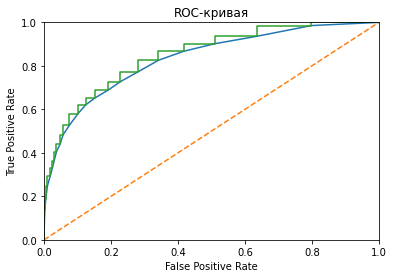

In [46]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.step(fpr, tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()


## Заключение

На основании данных о поведении клиентов и расторжении ими договоров с банком осуществлен прогноз ухода клиента из банка в ближайшее время. Для этого были построены три модели машинного обучения с подбором оптимальных метрик:

1. **Рассмотрены три модели машинного обучения, без учета дисбаланса классов**, получены следующие наилучшие значения f1-меры на валидационной выборке:

* **Модель"Дерево решений":** F1=0.592, при max_depth=7. AUC-ROC = 0.823
* **Модель "Случайный лес":** F1=0.611, при n_estimators=77. AUC-ROC = 0.860
* **Модель "Логистическая регрессия":** F1=0.305. AUC-ROC = 0.787

**Таким образом, наилучшие значения f1-меры у модели "Случайный лес": F1=0.611, при n_estimators=77. AUC-ROC = 0.860, качество лучше, чем у случайной модели.**

2. **Рассмотрены три модели машинного обучения**, получены следующие наилучшие значения f1-меры на валидационной выборке **с учетом применения техник для борьбы с дисбалансом классов**:

**Модель"Дерево решений":** 
* `взвешивание классов`: F1=0.576, при max_depth=6. AUC-ROC = 0.823.
* `upsampling (увеличение выборки)`: F1=0.576, при max_depth=6. AUC-ROC = 0.823.
* `downsampling (уменьшение выборки)`: F1=0.594, при max_depth=6. AUC-ROC = 0.848.

**Модель "Случайный лес":**
* `взвешивание классов`: F1=0.598, при n_estimators=21. AUC-ROC = 0.849.
* `upsampling (увеличение выборки)`: F1=0.628, при n_estimators=23. AUC-ROC = 0.855.
* `downsampling (уменьшение выборки)`: F1=0.606, при n_estimators=97. AUC-ROC = 0.857.

**Модель "Логистическая регрессия":**
* `взвешивание классов`: F1=0.529. AUC-ROC = 0.794.
* `upsampling (увеличение выборки)`: F1=0.529. AUC-ROC = 0.794.
* `downsampling (уменьшение выборки)`: F1=0.529. AUC-ROC = 0.793.

**Таким образом, наилучшие значения f1-меры у модели "Случайный лес" при использовании техники `upsampling`: F1=0.628, при n_estimators=23. AUC-ROC = 0.855.**

3. **Проведено тестирование лучшей модели** (модель "Случайный лес" с использованием техники upsampling и n_estimators=23) на тестовой выборки со следуюими результатами:
* F1-мера на тестовой выборке = 0.578
* AUC-ROC на тестовой выборке = 0.833
* Accuracy модели на тестовой выборке = 0.844